# Analysing GITT data

PyProBE includes built-in analysis methods for pulsing experiments, which this example
will demonstrate.

First import the required libraries and data:

In [1]:
import pyprobe

info_dictionary = {'Name': 'Sample cell',
                   'Chemistry': 'NMC622',
                   'Nominal Capacity [Ah]': 0.04,
                   'Cycler number': 1,
                   'Channel number': 1,}
data_directory = '../../../tests/sample_data/neware'

# Create a cell object
cell = pyprobe.Cell(info=info_dictionary)
cell.add_procedure(procedure_name='Sample',
                   folder_path = data_directory,
                   filename = 'sample_data_neware.parquet')
print(cell.procedure['Sample'].experiment_names)



['Initial Charge', 'Break-in Cycles', 'Discharge Pulses']


We will plot the Break-in Cycles and Discharge Pulses:

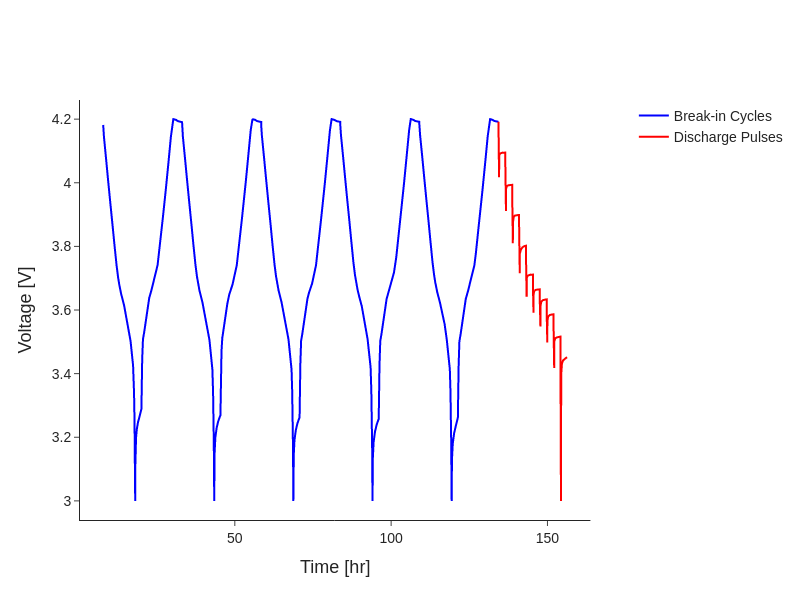

In [2]:
fig = pyprobe.Plot()
fig.add_line(cell.procedure['Sample'].experiment('Break-in Cycles'), 'Time [hr]', 'Voltage [V]', label = 'Break-in Cycles', color = 'blue')
fig.add_line(cell.procedure['Sample'].experiment('Discharge Pulses'), 'Time [hr]', 'Voltage [V]', label = 'Discharge Pulses', color = 'red')
fig.show_image()

State-of-charge is a useful metric when working with battery data, however it must be carefully defined. PyProBE doesn't automatically calculate a value for cell SOC until instructed to by the user for this reason.

To add an SOC column to the data, we call `set_SOC()` on the procedure. We are going to provide an argument to `reference_charge`. This will be the final charge of the break-in cycles. This argument instructs PyProBE that the final data point of this charge is our 100% SOC reference.

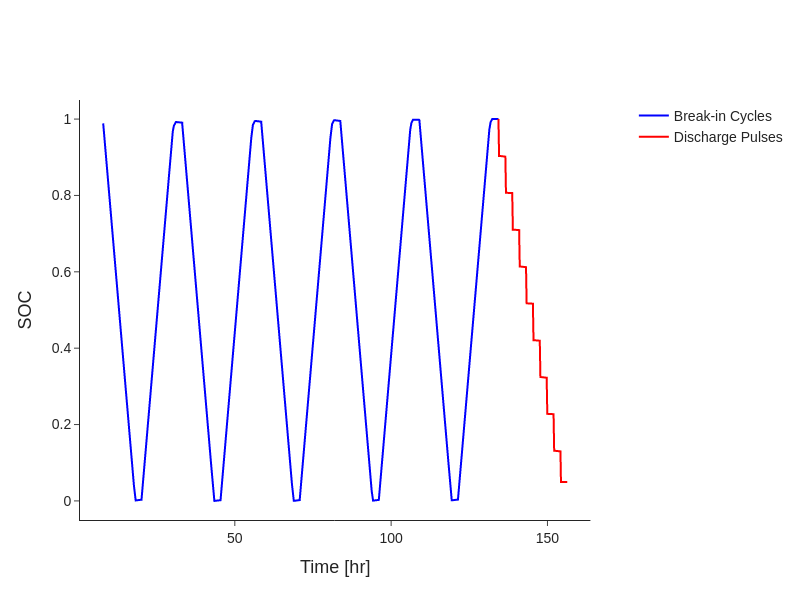

In [3]:
reference_charge = cell.procedure['Sample'].experiment('Break-in Cycles').charge(-1)
cell.procedure['Sample'].set_SOC(reference_charge=reference_charge)

fig = pyprobe.Plot()
fig.add_line(cell.procedure['Sample'].experiment('Break-in Cycles'), 'Time [hr]', 'SOC', label = 'Break-in Cycles', color = 'blue')
fig.add_line(cell.procedure['Sample'].experiment('Discharge Pulses'), 'Time [hr]', 'SOC', label = 'Discharge Pulses', color = 'red')
fig.show_image()

Then we'll filter to only the pulsing experiment:

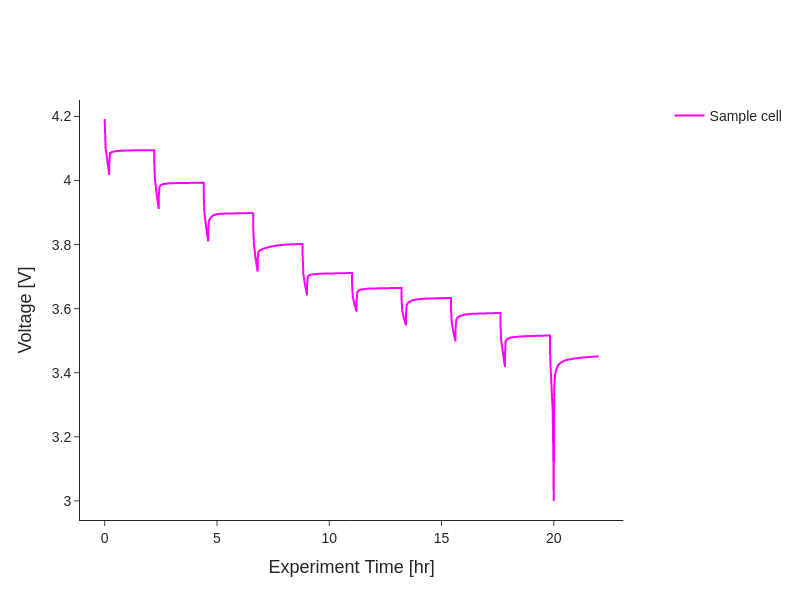

In [4]:
pulsing_experiment = cell.procedure['Sample'].experiment('Discharge Pulses')

fig = pyprobe.Plot()
fig.add_line(pulsing_experiment, 'Experiment Time [hr]', 'Voltage [V]')
fig.show_image()

And then create our pulsing analysis object.

In [5]:
from pyprobe.analysis.pulsing import Pulsing
pulse_object = Pulsing(input_data=pulsing_experiment)

With the pulsing object we can separate out individual pulses:

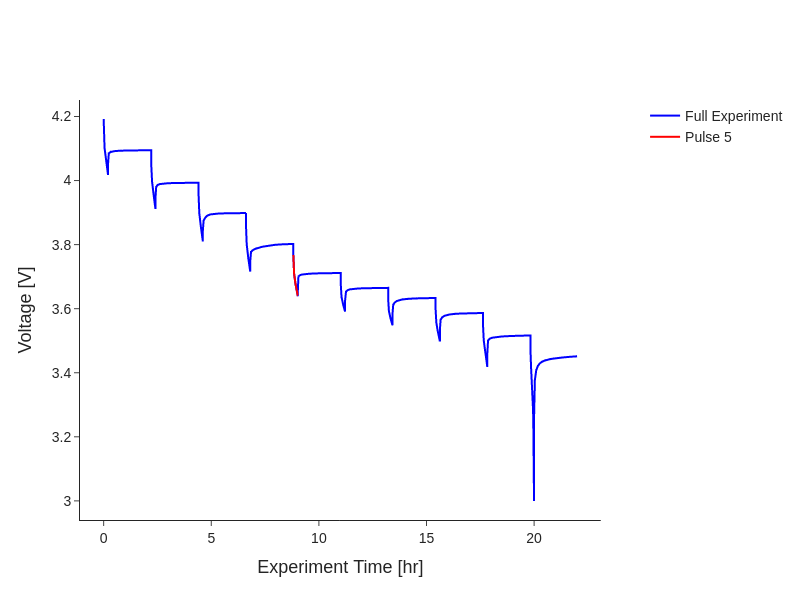

In [6]:
fig = pyprobe.Plot()
fig.add_line(pulse_object.input_data, 'Experiment Time [hr]', 'Voltage [V]', color='blue', label='Full Experiment')
fig.add_line(pulse_object.pulse(4), "Experiment Time [hr]", "Voltage [V]", label = 'Pulse 5', color = 'red')
fig.show_image()

We can also extract key parameters from the pulsing experiment, with the `pulse_summary()` method.

In [7]:
print(pulse_object.pulse_summary().data)

shape: (10, 5)
┌──────────────┬──────────────────────────┬──────────┬─────────┬───────────┐
│ Pulse number ┆ Experiment Capacity [Ah] ┆ SOC      ┆ OCV [V] ┆ R0 [Ohms] │
│ ---          ┆ ---                      ┆ ---      ┆ ---     ┆ ---       │
│ u32          ┆ f64                      ┆ f64      ┆ f64     ┆ f64       │
╞══════════════╪══════════════════════════╪══════════╪═════════╪═══════════╡
│ 1            ┆ 0.0                      ┆ 1.0      ┆ 4.1919  ┆ 1.805578  │
│ 2            ┆ -0.004                   ┆ 0.903497 ┆ 4.0949  ┆ 1.835632  │
│ 3            ┆ -0.008001                ┆ 0.806994 ┆ 3.9934  ┆ 1.775612  │
│ 4            ┆ -0.012001                ┆ 0.710493 ┆ 3.8987  ┆ 1.750596  │
│ 5            ┆ -0.016001                ┆ 0.613991 ┆ 3.8022  ┆ 1.725532  │
│ 6            ┆ -0.020002                ┆ 0.517489 ┆ 3.7114  ┆ 1.705558  │
│ 7            ┆ -0.024002                ┆ 0.420988 ┆ 3.665   ┆ 1.705622  │
│ 8            ┆ -0.028002                ┆ 0.324487 ┆ 3.6334

The pulse summary can take an argument of a list of times at which to evaluate the resistance after the pulse, for instance at 10s after the pulse:

In [8]:
pulse_summary = pulse_object.pulse_summary(r_times=[10])
print(pulse_summary.data)

shape: (10, 6)
┌──────────────┬──────────────────────────┬──────────┬─────────┬───────────┬──────────────┐
│ Pulse number ┆ Experiment Capacity [Ah] ┆ SOC      ┆ OCV [V] ┆ R0 [Ohms] ┆ R_10s [Ohms] │
│ ---          ┆ ---                      ┆ ---      ┆ ---     ┆ ---       ┆ ---          │
│ u32          ┆ f64                      ┆ f64      ┆ f64     ┆ f64       ┆ f64          │
╞══════════════╪══════════════════════════╪══════════╪═════════╪═══════════╪══════════════╡
│ 1            ┆ 0.0                      ┆ 1.0      ┆ 4.1919  ┆ 1.805578  ┆ 2.910931     │
│ 2            ┆ -0.004                   ┆ 0.903497 ┆ 4.0949  ┆ 1.835632  ┆ 2.805967     │
│ 3            ┆ -0.008001                ┆ 0.806994 ┆ 3.9934  ┆ 1.775612  ┆ 2.735943     │
│ 4            ┆ -0.012001                ┆ 0.710493 ┆ 3.8987  ┆ 1.750596  ┆ 2.685915     │
│ 5            ┆ -0.016001                ┆ 0.613991 ┆ 3.8022  ┆ 1.725532  ┆ 2.640815     │
│ 6            ┆ -0.020002                ┆ 0.517489 ┆ 3.7114  ┆ 

As a result object, the pulse summary can also be plotted:

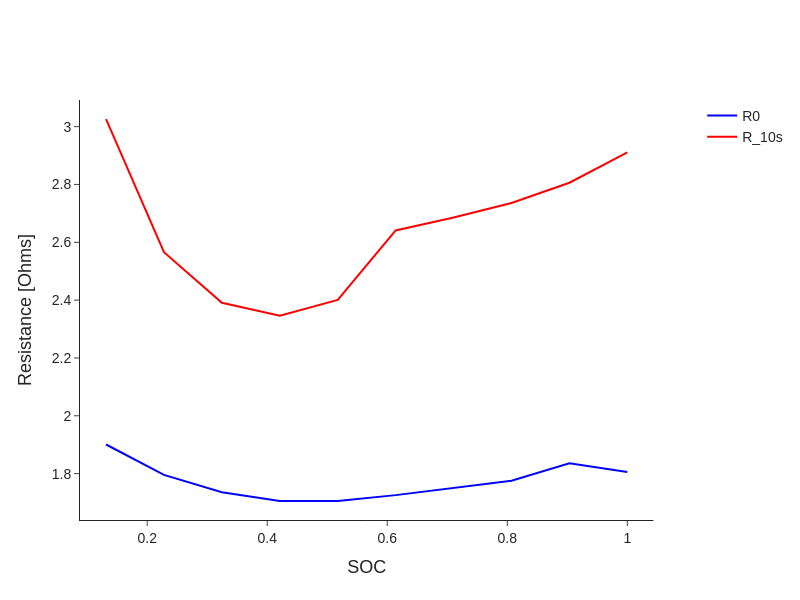

In [9]:
fig = pyprobe.Plot()
fig.add_line(pulse_summary, 'SOC', 'R0 [Ohms]', color='blue', label='R0')
fig.add_line(pulse_summary, 'SOC', 'R_10s [Ohms]', color='red', label='R_10s')
fig.yaxis_title = 'Resistance [Ohms]'
fig.show_image()